In [ ]:
#GoogleDriveからマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ライブラリインポート
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split


In [ ]:
#データの読み込みとリサイズ
def load_and_resize_images(directory, img_height, img_width):
    images = []
    for filename in sorted(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (img_width, img_height))
            img_resized = img_resized[..., np.newaxis]
            images.append(img_resized)
    return images

img_height, img_width = 256, 256

# 各データセットのディレクトリパスを指定
train_image_dir = "/content/drive/MyDrive/dataset_500/実験/train/images"
train_mask_dir = "/content/drive/MyDrive/dataset_500/実験/train/masks"

val_image_dir = "/content/drive/MyDrive/dataset_500/実験/val/images"
val_mask_dir = "/content/drive/MyDrive/dataset_500/実験/val/masks"

test_image_dir = "/content/drive/MyDrive/test/images"
test_mask_dir = "/content/drive/MyDrive/test/masks"

# 各データセットを読み込む
X_train = load_and_resize_images(train_image_dir, img_height, img_width)
y_train = load_and_resize_images(train_mask_dir, img_height, img_width)

X_val = load_and_resize_images(val_image_dir, img_height, img_width)
y_val = load_and_resize_images(val_mask_dir, img_height, img_width)

X_test = load_and_resize_images(test_image_dir, img_height, img_width)
y_test = load_and_resize_images(test_mask_dir, img_height, img_width)



In [ ]:
# 画像とマスクの形状を変更

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
#正規化
# 画像とマスクの形状を変更し、正規化を行う（これはそのままでOK）
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train) / 255.0
X_val = np.array(X_val) / 255.0
y_val = np.array(y_val) / 255.0
X_test = np.array(X_test) / 255.0
y_test = np.array(y_test) / 255.0

In [1]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def fcn_model(input_shape):
    inputs = Input(input_shape)

    # Encoder 1
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    # Encoder 2
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Encoder 3
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Encoder 4
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    # ここでは、さらに深い特徴を抽出するために畳み込みを追加することができます。
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)

    # Decoder 1
    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)

    # Decoder 2
    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u6)

    # Decoder 3
    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u7)

    # Decoder 4
    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u8)

    # 出力層
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u9)

    return Model(inputs=[inputs], outputs=[outputs])


# モデルのインスタンス化
input_shape = (256, 256, 1)
model = fcn_model(input_shape)


# モデルの要約（オプショナル）
# model.summary()



In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168

In [ ]:
import tensorflow as tf

# IoU関数の定義
def iou(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = intersection / union
    return iou

# 精度を計算する関数
def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_f, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# 再現率を計算する関数
def recall(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# F1スコアを計算する関数
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[iou, precision, recall, f1_score])

# 早期停止のコールバックを設定
early_stopping = EarlyStopping(
    monitor='val_loss',  # 監視する指標
    patience=10,         # 10エポック改善がなければ停止
    verbose=1,           # 進行状況のメッセージ表示
    restore_best_weights=True  # 最良のモデルの重みを復元
)


In [ ]:
# モデルのトレーニング（早期停止をコールバックとして追加）
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=50,  # 最大エポック数
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # 早期停止のコールバックを追加
)

Epoch 1/50
50/50 [==============================] - 29s 181ms/step - loss: 0.4304 - iou: 0.7292 - precision: 0.9066 - recall: 0.9847 - f1_score: 0.9418 - val_loss: 0.3358 - val_iou: 0.7830 - val_precision: 0.9051 - val_recall: 0.9996 - val_f1_score: 0.9496
Epoch 2/50
50/50 [==============================] - 8s 151ms/step - loss: 0.3208 - iou: 0.8201 - precision: 0.9077 - recall: 0.9997 - f1_score: 0.9513 - val_loss: 0.3163 - val_iou: 0.8574 - val_precision: 0.9053 - val_recall: 0.9998 - val_f1_score: 0.9498
Epoch 3/50
50/50 [==============================] - 8s 154ms/step - loss: 0.2899 - iou: 0.8347 - precision: 0.9075 - recall: 0.9995 - f1_score: 0.9511 - val_loss: 0.2802 - val_iou: 0.8299 - val_precision: 0.9050 - val_recall: 0.9994 - val_f1_score: 0.9495
Epoch 4/50
50/50 [==============================] - 8s 155ms/step - loss: 0.2482 - iou: 0.8493 - precision: 0.9073 - recall: 0.9993 - f1_score: 0.9510 - val_loss: 0.2318 - val_iou: 0.8534 - val_precision: 0.9048 - val_recall: 0.999

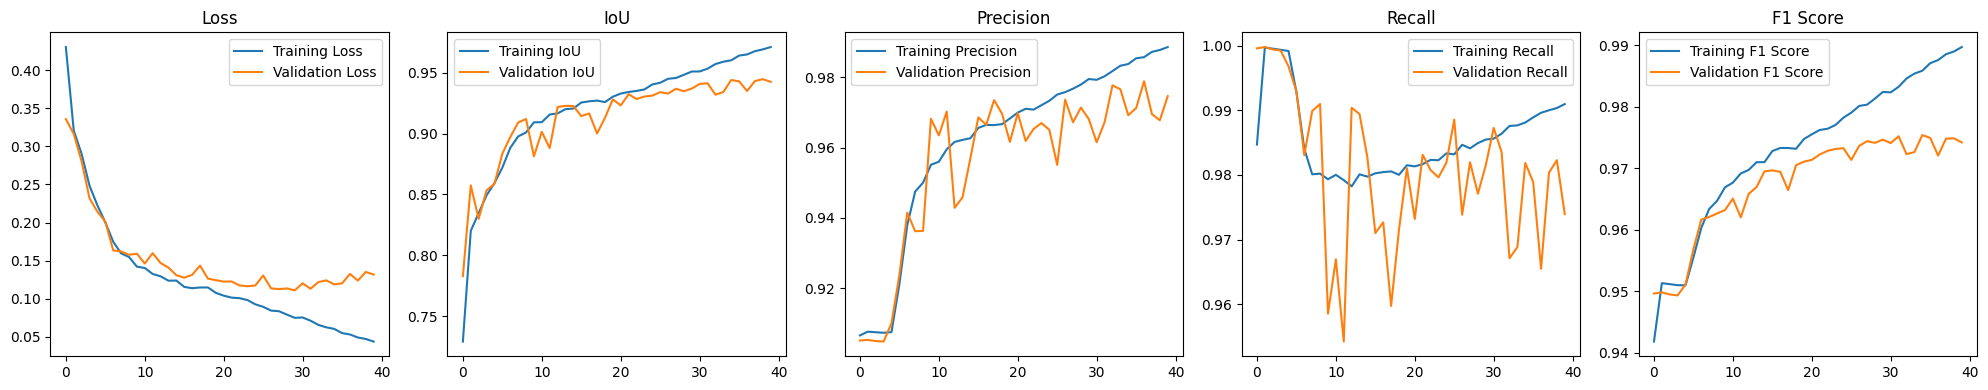

In [ ]:
import matplotlib.pyplot as plt
# 学習のロスと評価指標の履歴をプロット
plt.figure(figsize=(20, 4))

# ロスの履歴をプロット
plt.subplot(1, 5, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# IoUの履歴をプロット
plt.subplot(1, 5, 2)
plt.plot(history.history['iou'], label='Training IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.legend()
plt.title('IoU')

# 精度の履歴をプロット
plt.subplot(1, 5, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.legend()
plt.title('Precision')

# 再現率の履歴をプロット
plt.subplot(1, 5, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.legend()
plt.title('Recall')

# F1スコアの履歴をプロット（オプショナル）
plt.subplot(1, 5, 5)
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.legend()
plt.title('F1 Score')

plt.tight_layout()

# グラフを保存
plt.savefig('training_graphs.png')

plt.show()




In [ ]:
import os
from tensorflow.keras.models import Model

# 保存先のフォルダパスを指定
save_dir = '/content/drive/MyDrive/dataset_500/model'

# 指定したフォルダが存在しない場合は作成
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# モデルの保存先のパスを指定
model_save_path = os.path.join(save_dir, 'fcn_500_model.h5')

# モデルをHDF5形式で保存
model.save(model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(X_test, batch_size=4)

25/25 [==============================] - 1s 28ms/step


In [ ]:
threshold = 0.5
predictions_t = (predictions > threshold).astype(np.uint8)


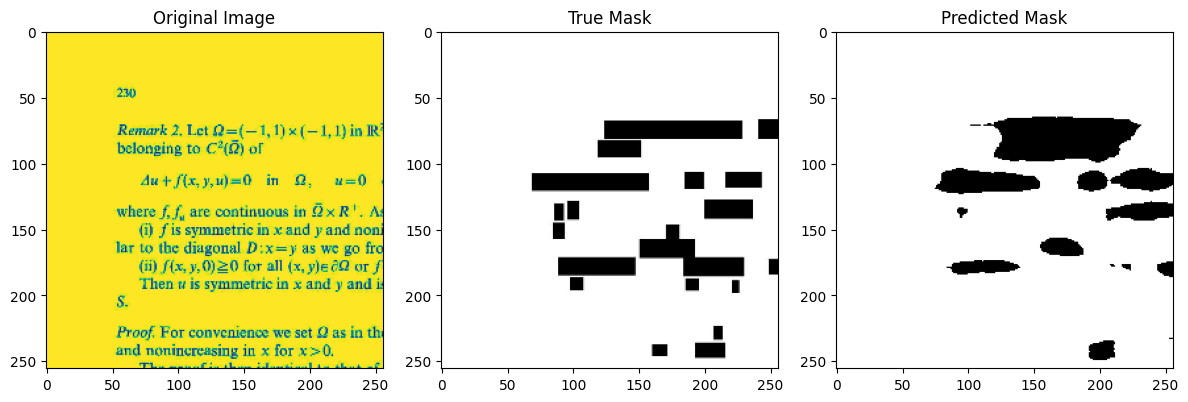

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # 表示する画像のインデックス

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[idx])
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test[idx].squeeze(), cmap='gray')
plt.title("True Mask")

plt.subplot(1, 3, 3)
plt.imshow(predictions_t[idx].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.savefig('result.png')
plt.show()
